In [1]:
cd ~/microbiome_rnn/

/Volumes/export/isn/mwiest/microbiome_rnn


In [2]:
from __future__ import print_function
%matplotlib inline
import os
import torch
import numpy as np
import pandas as pd
import sys
from otu_handler import OTUHandler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from models.rnn.conv_lstm import *
from models.rnn.lstm import *
from models.enc_dec.encoder_decoder import *
from matplotlib.cm import ScalarMappable

from models.ffn.ffn import *
from models.ffn.conv_ffn import *
from helpers.model_helper import *
from sklearn.metrics import mean_squared_error
import seaborn as sns

colors_generic = plt.rcParams['axes.prop_cycle'].by_key()['color']


In [3]:
# Some helper functions.

def get_primer_and_comparison_data(otu_handler,
                                   sample_index,
                                   start_index,
                                   primer_len,
                                   predict_len):
    primer = otu_handler.samples[sample_index].values[:, start_index: start_index + primer_len]
    # Need to make it 3d because the last dimension is how many predictions to do at once. 
    primer = np.expand_dims(primer, -1)
    # Get the comparison data.
    comparison = otu_handler.samples[sample_index].values[:, start_index:predict_len + start_index + primer_len]
    comparison = np.expand_dims(comparison, -1)
    return primer, comparison

def complete_and_multiindex_df(df, split_char):
    default_tax = ['k__', 'p__', 'c__', 'o__', 'f__', 'g__', 's__']
    s = list(df.index.values)
    lt = [list(ls.split(split_char)) for ls in s]
    lt = [[ltii.strip() for ltii in lti] for lti in lt]
    for l in lt:
        if len(l) < len(default_tax):
            l += default_tax[-(len(default_tax)-len(l)):]

    ltn = pd.DataFrame(np.array(lt))
    ltn.index = df.index
    ltn.columns = default_tax
    combined = pd.concat((df, ltn), axis=1)
    combined.set_index(default_tax, inplace=True)
    return combined

In [57]:
# This is just a nice label for the plotting
file_labs = ['Donor$_0$', 'Donor$_1$', 'Donor$_{2, 0}$', 'Donor$_{2, 1}$', 'Donor$_3$']

In [58]:
# Put the model type in here
model_type = 'enc_dec'
# What is the name of the model and logs outputted?
run_suffix = '_EncDec_h2048_sl5_rns62_sif2_numlstm1'

In [59]:


model_lookup = {
    'enc_dec': EncoderDecoder,
    'lstm': LSTM,
    'conv_lstm': ConvLSTM,
    'ffn': FFN,
    'conv_ffn': ConvFFN
}

model_outputs = {
    'enc_dec': 'enc_dec_output/',
    'lstm': 'rnn_output/',
    'ffn': 'ffn_output',
    'conv_ffn': 'ffn_output',
    'conv_lstm': 'rnn_output'
}

In [60]:
model_name = 'model{}.pt'.format(run_suffix)
log_name = 'log{}.npy'.format(run_suffix)
output_dir = model_outputs[model_type]


## Load in the data handler and pertinent data.

In [61]:
# What data to load to the data handler.
parent = 'input_data'
input_dir = 'all_studies_reduced_62/'
test_dir = 'all_studies_reduced_62_test/'

input_dir = os.path.join(parent, input_dir)
test_dir = os.path.join(parent, test_dir)

In [62]:
# Instantiate an OTU Handler.



input_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir)]
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir)]

# Uncomment this if you want to include the test data in the plots:
input_files += test_files
input_files.sort()
print(input_files)
otu_handler = OTUHandler(input_files)
otu_handler.normalize_data()
for s in otu_handler.samples:
    print(s.shape)

['input_data/all_studies_reduced_62/reference-hit_metadata_DonorA_stool_sorted_tax_completed_normalized_sub_62.csv', 'input_data/all_studies_reduced_62/reference-hit_metadata_DonorB_stool_sorted_tax_completed_normalized_sub_62.csv', 'input_data/all_studies_reduced_62/reference-hit_metadata_M03_stool_sorted_tax_completed_normalized_sub_62.csv', 'input_data/all_studies_reduced_62/reference-hit_metadata_M3_stool_sorted_tax_completed_normalized_sub_62.csv', 'input_data/all_studies_reduced_62_test/reference-hit_metadata_LS_feces_sorted_tax_completed_normalized_sub_62.csv']
(62, 335)
(62, 191)
(62, 266)
(62, 336)
(62, 38)


In [63]:
# How many taxonomy levels to include in the plots. 
# Higher numbers results in a a larger number of strains, ie less grouping
levels = 3
join_char = '\n'
split_char = ';'
# Reindex the dataframes
multi_samples = [complete_and_multiindex_df(s, split_char) for s in otu_handler.samples]

# Get various pieces of data about the taxonomy.
grouped = [ms.groupby(level=list(range(0, levels))) for ms in multi_samples]
# Taxonomy names
labels = [join_char.join(c) for c in grouped[0].count().index]

# Get color labels so that we can color the points based on taxonomy.
labs = [join_char.join(c[0:levels]) for c in multi_samples[0].index.values]
full_labs = [join_char.join(c.split(split_char)) for c in otu_handler.samples[0].index.values]

unique_ints = list(range(len(labels)))
unique_int_lookup = dict(zip(labels, unique_ints))
labs_to_ints = [unique_int_lookup[l] for l in labs]
print('There are {} distinct groups'.format(len(labels)))

# Now define the colormap
num_colors = len(list(set(labs)))
cmap = plt.cm.get_cmap('tab20', num_colors)
colors = cmap(np.linspace(0, 1, num_colors))
color_lookup = dict(zip(labels, colors))
colors_to_plot = np.array([color_lookup[l] for l in labs])
print(colors_to_plot.shape)

There are 13 distinct groups
(62, 4)


# Plot the Training Loss

In [64]:
losses = np.load(os.path.join(output_dir, log_name))
print(losses.shape)

(3, 62, 30)


Text(0.5,1,'Loss Over Training')

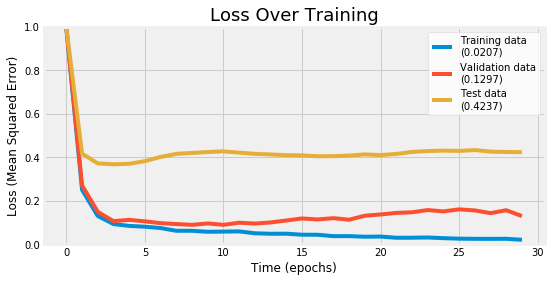

In [65]:
loss_num_digits = 6

plt.figure(figsize=(8, 4))
loss_labels = ['Training data\n({})', 'Validation data\n({})', 'Test data\n({})']

for i in range(losses.shape[0]):
    plt.plot(losses[i, ...].sum(axis=0).T, label=loss_labels[i].format(str(losses[i, :, -1].sum())[:loss_num_digits]))
legend = plt.legend(frameon = 1, loc='upper right')
frame = legend.get_frame()
frame.set_facecolor('white')
plt.xlabel('Time (epochs)')
plt.ylabel('Loss (Mean Squared Error)')
plt.ylim(0, 1)
plt.title('Loss Over Training', fontsize=18)


## Plot loss per strain at the end of training

(3, 62, 30)


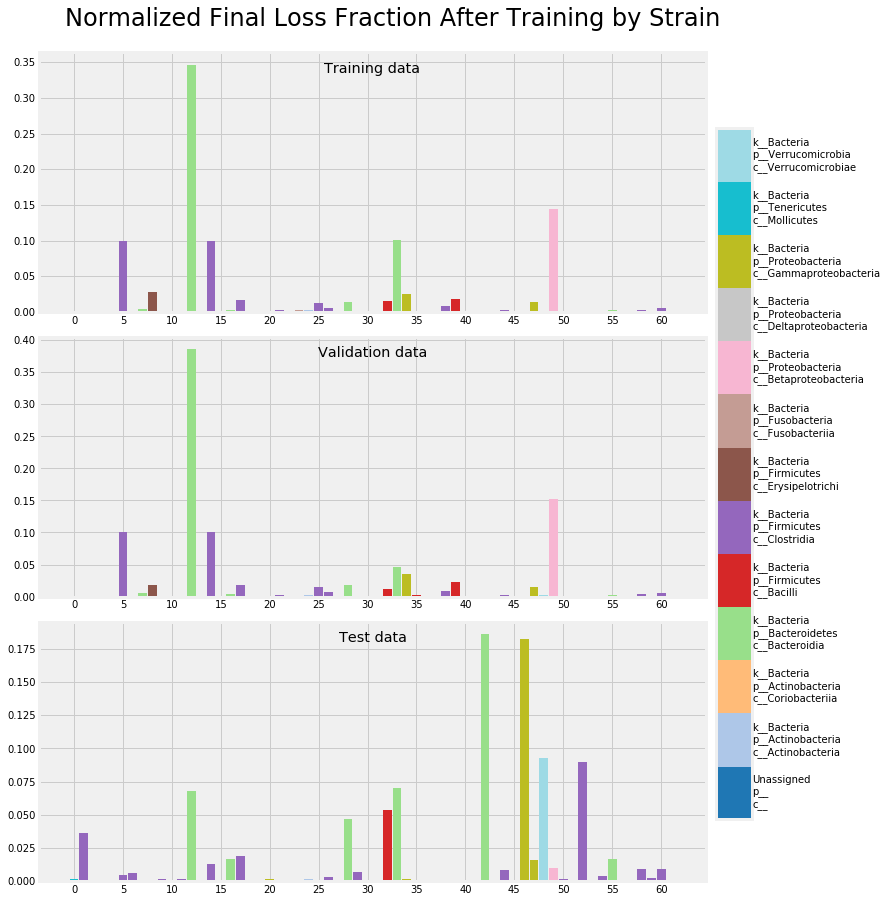

In [66]:
print(losses.shape)
fig, ax = plt.subplots(3, 1, figsize=(10, 12))
bar_width = 0.90
axl = ax.flatten()
for i in range(losses.shape[0]):
    rects1 = axl[i].bar(np.arange((losses.shape[1])), losses[i,:, -1] / losses[i, :, -1].sum(), bar_width, color=colors_to_plot)
    axl[i].set_title(loss_labels[i][:-5], y=0.9)
    axl[i].set_xticks(list(range(losses.shape[1]))[::5])
#     axl[i].set_xticklabels
    plt.tight_layout()
sm = ScalarMappable(cmap=cmap)
sm.set_array([])
cbar_ax = fig.add_axes([1, 0.1, 0.05, 0.8])
cb = plt.colorbar(sm, cax=cbar_ax)
cb.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(labels):
    cb.ax.text(1, (2 * j + 1) / 26.0, lab, ha='left', va='center', fontsize=10)
plt.suptitle('Normalized Final Loss Fraction After Training by Strain', fontsize=24, y=1.04, x=0.55)
plt.show()

# Model "Dreaming" Analysis

In [67]:
# Instantiate the model
hidden_dim = 2048
reduced_num_strains = 62
slice_len = 62
num_lstm = 1
use_gpu = torch.cuda.is_available()


# Basically load the correct type of model. 
if model_type == 'enc_dec' or model_type.endswith('lstm'):
    model = model_lookup[model_type](hidden_dim, otu_handler, num_lstm, use_gpu, LSTM_in_size=reduced_num_strains)
else:
    model = model_lookup[model_type](hidden_dim, otu_handler, slice_len, use_gpu)
print(model_name)    
model.load_state_dict(torch.load(os.path.join(output_dir, model_name)))
model = model.cuda()

model_EncDec_h2048_sl5_rns62_sif2_numlstm1.pt


## Plot a set of predictions from the model

In [68]:
# Just a little math to figure out the dimensions of the plots. Because the number of samples could be variable.
num_cols = 2
num_rows = int(len(otu_handler.samples) / num_cols) + (len(otu_handler.samples) % num_cols)
subplot_height = num_rows * 5
subplot_width = num_cols * 10

In [73]:
# How far into the dataset to start for a primer.
start_fraction = 0.82
primer_len = 7
predict_length = 30
# Range of strain indices to plot.
# r = range(4, 7)
# r = [1, 10, 4]
r = [1, 15, 20]
starts = [0.82] * 4 + [0.0]
# Can reconfigure this to actually display relevant strain names.
labels = ['Strain: {}'.format(ri) for ri in r]

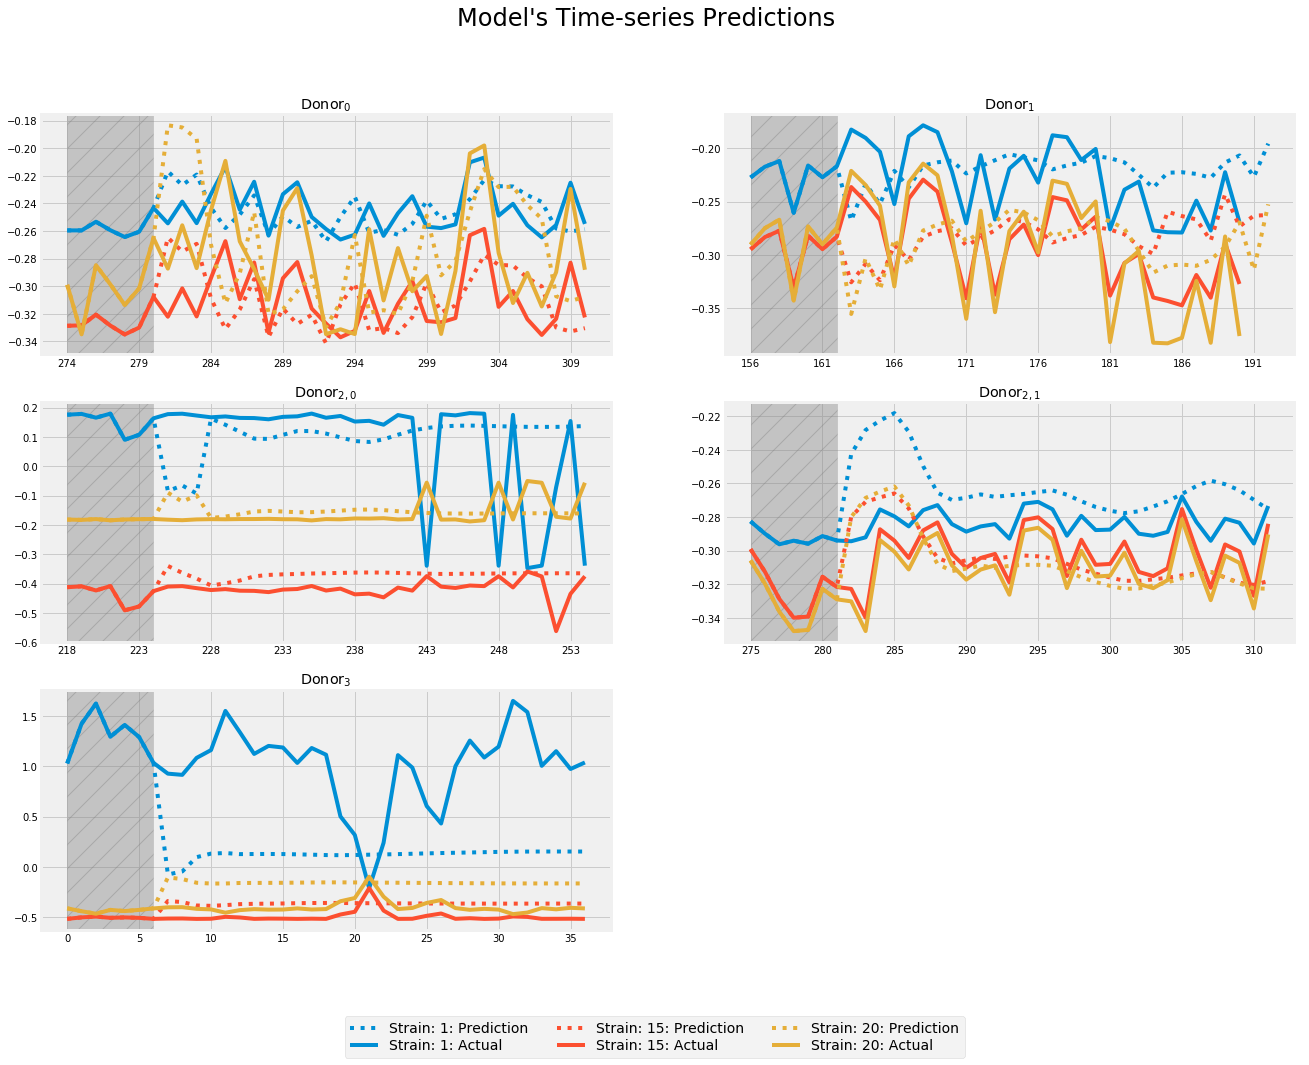

In [74]:
%matplotlib inline

# Generate subplots of the same data as above.
fig, ax = plt.subplots(num_rows, num_cols, figsize=(subplot_width, subplot_height))
axl = ax.flatten()


# labels = ['Prediction', 'Actual']
for i, s in enumerate(otu_handler.samples):
    start_index = int(starts[i] * s.shape[1])
    primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                        i, 
                                                        start_index, 
                                                        primer_len, 
                                                        predict_length)
    dream = model.daydream(primer, predict_len=predict_length)
    
    if i == 0:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':',
                        c=colors_generic[j],
                        label='{}: Prediction'.format(labels[j]))
            axl[i].plot(comparison[ri, :, 0].T, 
                        c=colors_generic[j], 
                        label='{}: Actual'.format(labels[j]))
    else:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':', 
                        c=colors_generic[j],
                        label='_nolegend_')
            axl[i].plot(comparison[ri, :, 0].T, 
                        c=colors_generic[j],
                        label='_nolegend_')
    axl[i].axvspan(0, (primer_len) - 1, alpha=0.4, color='gray',
                label='_nolegend_', hatch='/')
    axl[i].set_xticks(list(range(primer_len + predict_length))[::5])
    axl[i].set_xticklabels(list(range(start_index, start_index + primer_len + predict_length))[::5])
    axl[i].set_title(file_labs[i])

# Cleanup
if num_rows * num_cols != len(otu_handler.samples):
    ax[-1, -1].axis('off')
    
fig.legend(loc='lower center', ncol=len(r), labelspacing=0.2, fontsize=14)
plt.suptitle('Model\'s Time-series Predictions', fontsize=24)
plt.show()
    

# Analysis of primer length on accuracy
Quantify how the length of the primer region affects the accuracy of the predictions

In [18]:
# How far into the dataset to start for a primer.
start_fractions = [0.2] * 4 + [0.0]
primer_lens = list(range(2, 15))
predict_length = 22

losses = np.zeros((len(model.otu_handler.samples), len(primer_lens)))
for i, s in enumerate(model.otu_handler.samples):
    start_index = int(model.otu_handler.samples[i].shape[1] * start_fractions[i])
    print(model.otu_handler.samples[i].shape)
    for j, primer_len in enumerate(primer_lens):
        primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                            i, 
                                                            start_index, 
                                                            primer_len, 
                                                            predict_length)
        dream = model.daydream(primer, predict_len=predict_length)
        loss = mean_squared_error(dream[:, primer_len:, 0], comparison[:, primer_len:, 0])
        losses[i, j] = loss
    print('Finished strain {} out of {}'.format(i + 1, len(model.otu_handler.samples)))

(62, 335)
Finished strain 1 out of 5
(62, 191)
Finished strain 2 out of 5
(62, 266)
Finished strain 3 out of 5
(62, 336)
Finished strain 4 out of 5
(62, 38)
Finished strain 5 out of 5


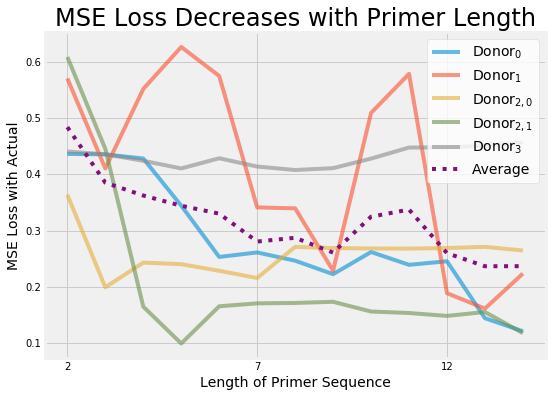

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(losses.shape[0]):
    plt.plot(losses[i, :], label=file_labs[i], alpha=0.6)
plt.plot(losses.mean(axis=0), label='Average', ls=':')
ax.set_xticks(range(len(primer_lens))[::5])
ax.set_xticklabels(primer_lens[::5])
plt.xlabel('Length of Primer Sequence', fontsize=14)
plt.ylabel('MSE Loss with Actual', fontsize=14)
plt.title('MSE Loss Decreases with Primer Length', fontsize=24)
legend = plt.legend(frameon = 1, loc='upper right', fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('white')

plt.show()

# Strain knockout analysis
Imagine that we have knocked out certain strains in the primer region (counts to zero). See how that affects the predictions.

In [100]:
# How far into the dataset to start for a primer.
start_fraction = 0.8
primer_len = 15
predict_length = 30
# Range of strain indices to plot.
r = range(3, 6)
# r = [4, 5, 6]
which_sample = 0
# Can reconfigure this to actually display relevant strain names.
labels = ['Strain: {}'.format(ri) for ri in r]

In [101]:
primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                        which_sample, 
                                                        start_index, 
                                                        primer_len, 
                                                        predict_length)


In [102]:
primerKO = primer.copy()

# Where to perform the knockouts
# knockouts = range(4, 6)
knockouts = [6]

knockout_val = -1

primerKO[knockouts, :, :] = knockout_val

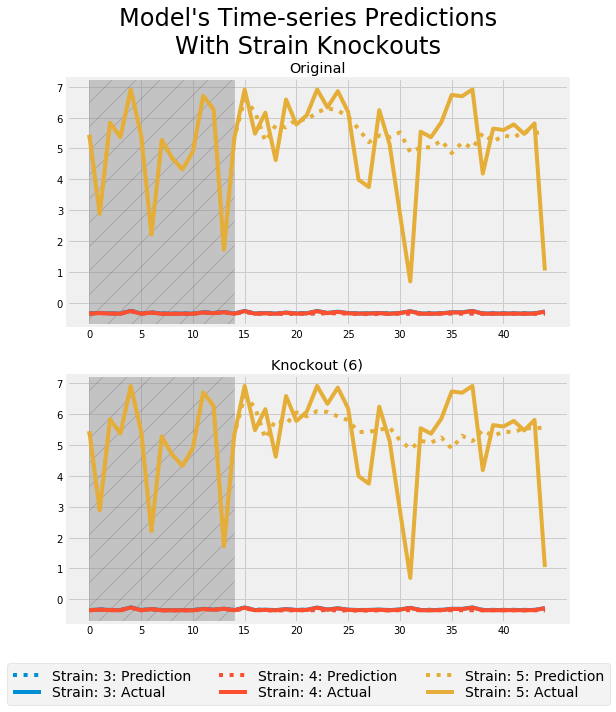

In [103]:
fig, ax = plt.subplots(2, 1, figsize=(8, 10))
axl = ax.flatten()

ko_labels = ['Original', 'Knockout ({})'.format(', '.join([str(s) for s in knockouts]))]

for i, p in enumerate([primer, primerKO]):
    dream = model.daydream(p, predict_len=predict_length)
    if i == 0:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':', c=colors_generic[j], label='{}: Prediction'.format(labels[j]))
            axl[i].plot(comparison[ri, :, 0].T, c=colors_generic[j], label='{}: Actual'.format(labels[j]))
    else:
        for j, ri in enumerate(r):
            axl[i].plot(dream[ri, :, 0].T, ls=':', c=colors_generic[j], label='_nolegend_')
            axl[i].plot(comparison[ri, :, 0].T, c=colors_generic[j], label='_nolegend_')
    axl[i].axvspan(0, (primer_len) - 1, alpha=0.4, color='gray',
                label='_nolegend_', hatch='/')
    axl[i].set_xticks(list(range(primer_len + predict_length))[::5])
    axl[i].set_xticklabels(list(range(start_index, start_index + primer_len + predict_length))[::5])
    axl[i].set_title(ko_labels[i])

    
fig.legend(loc='lower center', ncol=len(r), labelspacing=0.2, fontsize=14)
plt.suptitle('Model\'s Time-series Predictions\nWith Strain Knockouts', fontsize=24)
plt.show()

# Quantification of knockout effect
To better understand what is happening with the knockouts, we will knock out strains one by one and then see how that affects the loss of predictions

In [76]:
# How far into the dataset to start for a primer.
start_fraction = 0.8
primer_len = 15
predict_length = 30
knockout_val = -2
which_sample = 1

# Can reconfigure this to actually display relevant strain names.
labels = ['Strain: {}'.format(ri) for ri in r]

In [77]:
# This is the generic data prior to knockout.
# The comparison here is what will have its loss compared against.
primer, comparison = get_primer_and_comparison_data(otu_handler, 
                                                        which_sample, 
                                                        start_index, 
                                                        primer_len, 
                                                        predict_length)

dream_original = model.daydream(primer, predict_len=predict_length)[:, :, 0]
strain_errors = np.zeros((1, model.otu_handler.num_strains))
for i in range(dream_original.shape[0]):
    strain_errors[0, i] = mean_squared_error(dream_original[i, primer_len:], comparison[i, primer_len:])

strain_errors = np.repeat(strain_errors, model.otu_handler.num_strains, axis=0)


In [78]:
# For each strain, knock it out and get a row of data with the losses of the strains. 
ko_errors = np.zeros((model.otu_handler.num_strains, model.otu_handler.num_strains))
kos = []
for i in range(model.otu_handler.num_strains):
    pc = primer.copy()
    pc[i, ...] = knockout_val
    dream_ko = model.daydream(pc, predict_len=predict_length)[:, :, 0]
    for j in range(dream_ko.shape[0]):
        if i == j:
            ko_errors[i, j] = None
        else:
            ko_errors[i, j] = mean_squared_error(dream_ko[j, primer_len:], 
                                                 comparison[j, primer_len:]
                                                )

Text(40.1,0.5,'Knocked out Strain')

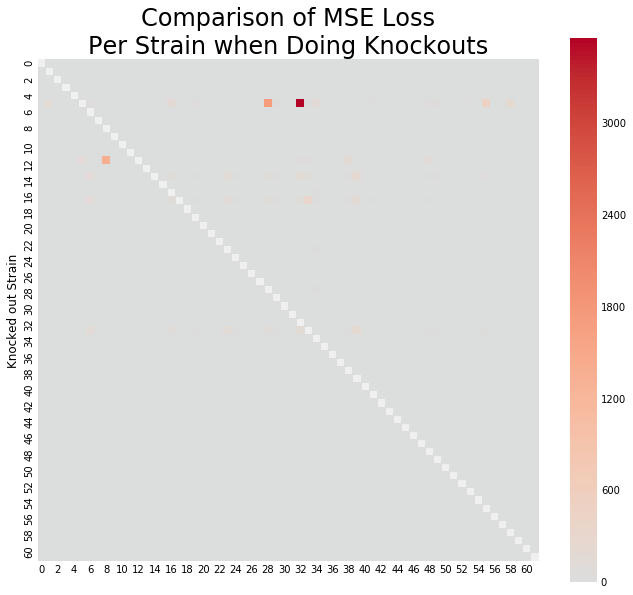

In [79]:
plt.figure(figsize=(10, 10))
sns.heatmap((ko_errors - strain_errors) / strain_errors, square=True, cmap='coolwarm', center=0)
plt.title('Comparison of MSE Loss\nPer Strain when Doing Knockouts', fontsize=24)
plt.ylabel('Knocked out Strain')
